In [1]:
from network import *
import numpy as np 
from scipy.sparse import csr_matrix
from scipy.stats import moment
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt("connections.csv", delimiter=",")
N = int(np.max(data)) + 1
A = csr_matrix((np.ones(len(data)), (data[:, 0], data[:, 1])), shape = (N, N), dtype = np.int32)
A = A + A.T
A = 1*(A > 0)

In [3]:
#getting the degrees of the matrix
kmin = 15
degrees = get_degrees(A)

#getting the pdf of the nodes degrees
uniques, pdf = get_neighbours_pdf(degrees)

#getting the cumulative distribution function
cumpdf = ccdf(pdf)

#estimating the parameters to be used in the power law
gamma, c = estimate_power_law(degrees, kmin)
C = c*cumpdf[np.where(uniques == kmin)]
print("gamma = ", gamma)
print("Average degree = ", np.mean(degrees))
print("Statistical power = ", moment(degrees, moment = 2))
print("Third moment = ", moment(degrees, moment = 3))

gamma =  2.450748070781991
Average degree =  12.2991452991453
Statistical power =  [394.73957192]
Third moment =  [41757.00181942]


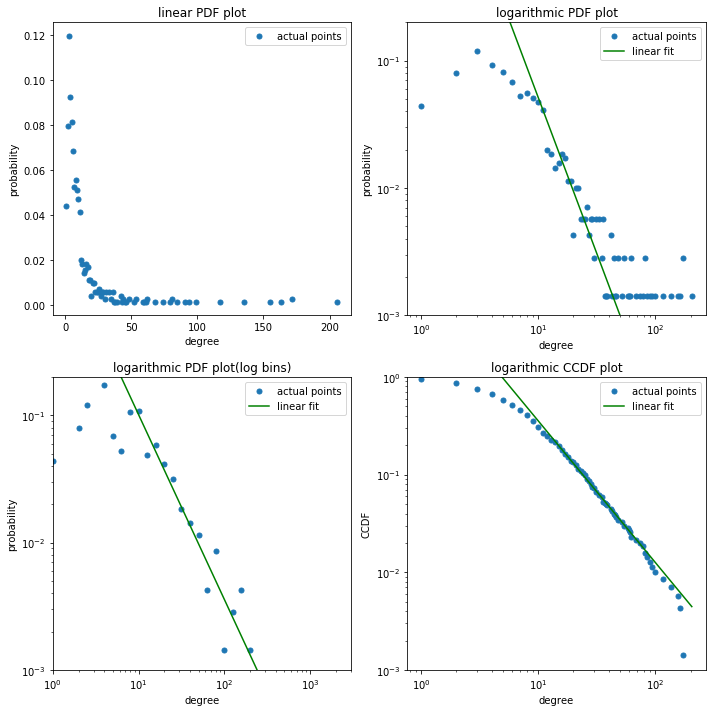

In [4]:
%matplotlib inline
fig, axs = plt.subplots(2, 2, figsize = (10, 10))

#plotting the pdf
axs[0, 0].set_title("linear PDF plot")
axs[0, 0].plot(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 0].set(xlabel='degree', ylabel='probability')
axs[0, 0].legend(["actual points"])

#plotting the pdf and the linear fit
axs[0, 1].set_title("logarithmic PDF plot")
axs[0, 1].set_ylim(1e-5, 1)
axs[0, 1].loglog(uniques, pdf, marker='o', linestyle='None', ms = 5)
axs[0, 1].loglog(np.arange(1, np.max(uniques)), C * (np.arange(1, np.max(uniques)) ** -gamma), c="green")
axs[0, 1].set(xlabel='degree', ylabel='probability')
axs[0, 1].set_ylim(0.001, 0.2)
axs[0, 1].legend(["actual points", "linear fit"])

#plotting the linear binning pdf
axs[1, 0].set_title("logarithmic PDF plot(log bins)")
axs[1, 0].set_xlim(1, 3*10e2)
axs[1, 0].set_ylim(1e-4, 1)
x, y = log_binning_pdf(0.1, degrees)
axs[1, 0].loglog(x, y, marker='o', linestyle='None', ms = 5)
axs[1, 0].loglog(x, C / (gamma - 1) * x ** (1 - gamma) * (1 - (x[1] / x[0]) ** (1 - gamma)), c="green")
axs[1, 0].set(xlabel='degree', ylabel='probability')
axs[1, 0].set_ylim(0.001, 0.2)
axs[1, 0].legend(["actual points", "linear fit"])


#plotting the ccdf and the corresponding linear fit
axs[1, 1].set_title("logarithmic CCDF plot")
axs[1, 1].set_ylim((1e-5, 1))
axs[1, 1].loglog(uniques, ccdf(pdf), marker='o', linestyle='None', ms = 5)
axs[1, 1].loglog(np.arange(1, np.max(uniques)), C * np.arange(1, np.max(uniques))**(1-gamma)/(gamma-1), c="green")
axs[1, 1].set(xlabel='degree', ylabel='CCDF')
axs[1, 1].set_ylim(0.001, 1)
axs[1, 1].legend(["actual points", "linear fit"])

#used to prevent label overlapping
fig.tight_layout()

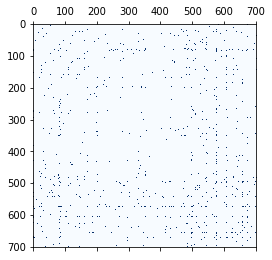

In [5]:
plt.matshow(A.toarray(), cmap="Blues")

In [6]:
characters_id = []
with open("nodes.csv", "r") as fp:
    for line in fp:
        name, name_ID = line.replace("\n", "").split(",")
        characters_id.append(name)

In [7]:
indexes = np.argsort(degrees, axis = 0)
for i in indexes[-1:-4:-1, 0]:
    print(characters_id[i])

Tyrion Lannister
Jaime Lannister
Arya Stark


In [8]:
print(N)
A = clean_network(A)
print(A.shape)

702
(702, 702)


max distance =  4.0
average distance =  2.693352191212391


Text(0.5, 1.0, 'Number of characters that need n hops to reach another character')

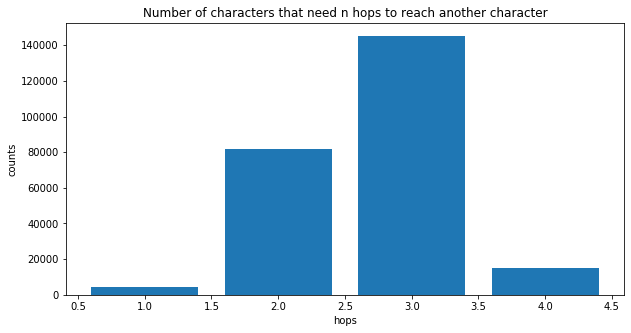

In [9]:
distances, counts = get_distance_distribution(A)
print("max distance = ", distances[-1])
print("average distance = ", np.sum(distances * counts)/np.sum(counts))
plt.figure(figsize=(10, 5))
plt.bar(distances, counts)
plt.xlabel("hops")
plt.ylabel("counts")
plt.title("Number of characters that need n hops to reach another character")

(array([ 32.,   6.,   4.,   8.,  13.,  15.,  22.,  32.,  29.,  41.,  39.,
         47.,  36.,  54.,  33.,  16.,  40.,  16.,  23., 196.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

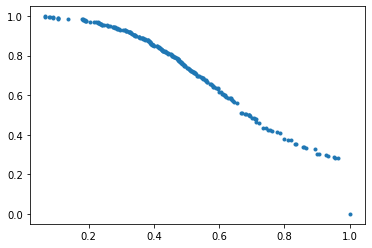

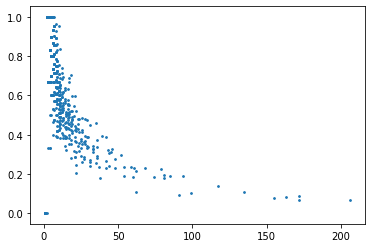

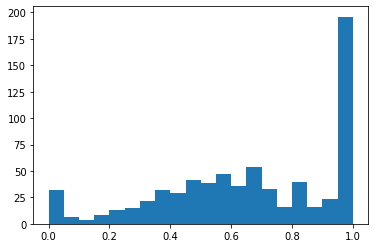

In [10]:
x, y = get_clustering_distribution(A)
plt.plot(x, ccdf(y), marker=".", linestyle = "None")
plt.figure()
clustering = get_clustering_coefficients(A)
plt.scatter(degrees, clustering, s = 3)
plt.figure()
plt.hist(clustering, bins=20)

In [11]:
print(np.mean(clustering), np.log(N)**2/N)
#print(clustering[:, np.newaxis]*)
print(np.sum(clustering[:, np.newaxis]*degrees)/np.sum(degrees))

0.6641911379562027 0.06118809553334096
0.43798351600224067


mu =  -0.22484447376121056
Natural cutoff = 1374.2639831073313
Structural cutoff = 92.91931984253867


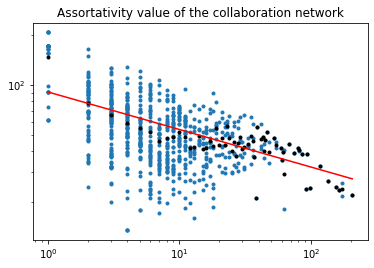

In [29]:
p, unique, knn, temp_knn = get_assortativity_value(A)
degrees = remove_zeros(get_degrees(A))

plt.title("Assortativity value of the collaboration network")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'r')
print("mu = ",p[0])
print(f"Natural cutoff = {kmin * N ** (1 / (gamma - 1))}")
print(f"Structural cutoff = {np.sum(degrees)**0.5}")
plt.show()

In [13]:
nodes = [[]]
i = 0
with open("connections_for_temp.csv", "r") as fp:
    for line in fp:
        if line == "end\n":
            i += 1
            nodes.append([])
        else:
            nodes[i].append([int(i) for i in line.replace("\n","").split(',')])            

In [14]:
import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

temporal_A = sp.sparse.csr_matrix((N,N))
temporal_distributions = get_temporal_distribution(temporal_A, nodes)

In [15]:
def parse_distribution(char_dist):
    char_dist_without_duplicates = set(char_dist)
    char_dist_sorted = list(char_dist_without_duplicates)
    char_dist_sorted.sort()
    return np.array(char_dist_sorted)

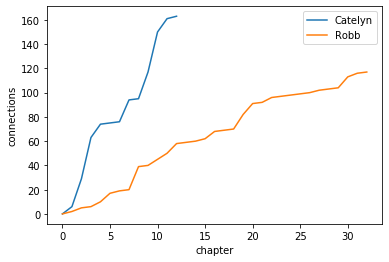

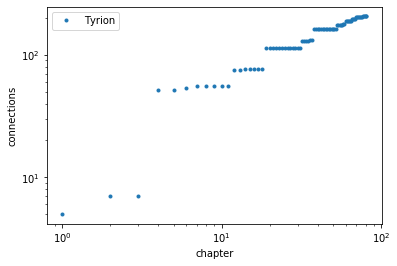

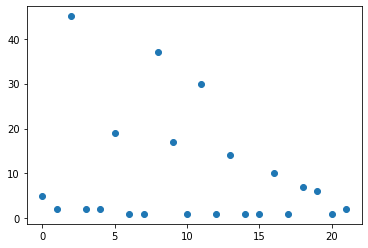

In [16]:
catelyn = temporal_distributions[:, characters_id.index("Catelyn Stark") ,0]
robb = temporal_distributions[:, characters_id.index("Robb Stark") ,0]
plt.plot(parse_distribution(catelyn))
plt.plot(parse_distribution(robb))
plt.xlabel("chapter")
plt.ylabel("connections")
plt.legend(["Catelyn", "Robb"])
plt.figure()
tyrion = temporal_distributions[:, characters_id.index("Tyrion Lannister") ,0]
plt.loglog(tyrion, marker = '.', linestyle="None")
plt.xlabel("chapter")
plt.ylabel("connections")
plt.legend(["Tyrion"])
diffs = np.diff(parse_distribution(tyrion))
meaningful_diffs = diffs[diffs > 7]
unmeaningful_diffs = diffs[diffs < 8]
plt.figure()
plt.scatter(np.arange(len(diffs)), diffs)

In [17]:
def gamma_CDF(x, alpha, beta):
    return sp.special.gammainc(alpha, beta*x)
def gamma_PDF(x, alpha, beta):
    return beta**alpha/sp.special.gamma(alpha)*x**(alpha-1)*np.exp(-beta*x)

The parameters found for the gamma function are:
alpha = 4.422235422188573
beta = 0.04353806976103228


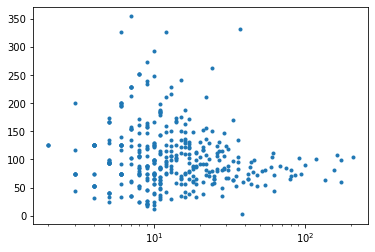

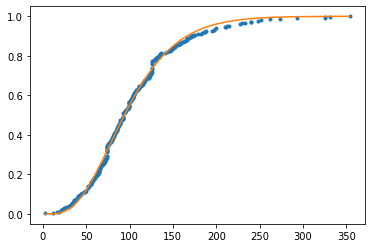

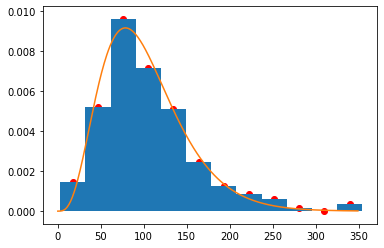

In [18]:
coeffs = []
m = A.shape[0]
for i in range(m):
    character = parse_distribution(temporal_distributions[:, i, 0])
    x = np.arange(1, len(character) + 1)
    if character[0] == 0:
        character = character[1:]
        x = x[1:] 
    if len(x) > 1:
        p = sp.polyfit(np.log(x), np.log(character), 1)
        coeffs.append(p[0])
        #plt.loglog(x, x ** p[0])
    else: coeffs.append(-1)
plt.figure()
coeffs = np.array(coeffs)
useful_degrees = degrees[coeffs != -1]
coeffs = coeffs[coeffs != -1] * c
plt.plot(useful_degrees, coeffs, marker = '.', linestyle = "None")
plt.xscale("log")
plt.figure()
unique, pdf = get_neighbours_pdf(coeffs)
plt.plot(unique, 1 - ccdf(pdf), marker = '.', linestyle="None")
p, var = sp.optimize.curve_fit(gamma_CDF, unique, 1-ccdf(pdf))
plt.plot(unique, gamma_CDF(unique, *p))
plt.figure()
temp = plt.hist(coeffs, density = True, bins = 12)
counts = temp[0]
bins = temp[1]
bin_cent = (bins[1:]+bins[:-1])/2
plt.scatter(bin_cent, counts, c = "red")
plt.plot(np.arange(0, 350, 1), gamma_PDF(np.arange(0, 350, 1), *p))
print("The parameters found for the gamma function are:")
print(f"alpha = {p[0]}")
print(f"beta = {p[1]}")

In [19]:
ids = np.argsort(coeffs)[::-1]
print(characters_id[ids[0]])
print(characters_id[ids[1]])
print(characters_id[ids[2]])
print(characters_id[ids[3]])
print(characters_id[ids[4]])
print(characters_id[ids[5]])


Garlan Tyrell
Grey-bearded Hamish
Joth Quick-bow
Gregor Clegane
Falyse
Helman Tallhart


Text(0, 0.5, 'fitness/degree')

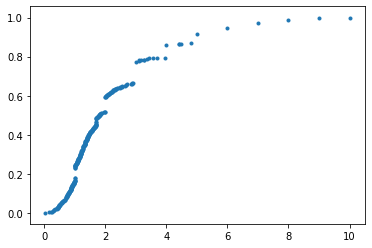

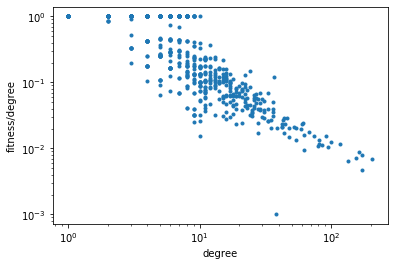

In [20]:
fitnesses = np.zeros(temporal_distributions.shape[1])
for i in range(temporal_distributions.shape[1]):
    y = parse_distribution(temporal_distributions[:, i, 0])
    x = np.arange(1, len(y) + 1)
    x = x[y > 0]
    y = y[y > 0]
    if len(y) > 1:
        p = np.polyfit(np.log(x), np.log(y), 1)
        fitnesses[i] = p[0]
    else:
        fitnesses[i] = y
unique, pdf = get_neighbours_pdf(fitnesses)
plt.scatter(unique, 1-ccdf(pdf), marker='.', linestyle = "None")
plt.figure()
plt.loglog(degrees, fitnesses/degrees, linestyle = "None", marker = '.')
plt.xlabel("degree")
plt.ylabel("fitness/degree")

alpha = 2.337952514964365 with 2.0196268933879358% of error
beta = 1.0964512532960509 +- 2.5547136960986494% of error


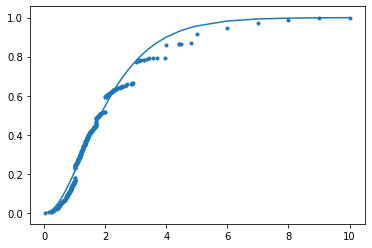

In [21]:
from scipy.special import gammainc
from scipy.optimize import curve_fit


p, cov = curve_fit(gamma_CDF, unique, 1-ccdf(pdf))
plt.scatter(unique, 1-ccdf(pdf), marker='.', linestyle = "None")
plt.plot(unique, gamma_CDF(unique, p[0], p[1]))
print(f"alpha = {p[0]} with {np.sqrt(cov[0,0])/p[0]*100}% of error")
print(f"beta = {p[1]} +- {np.sqrt(cov[1,1])/p[1]*100}% of error")

In [22]:
np.log(np.log(N))

1.8800653891059582

-0.030399171988245297


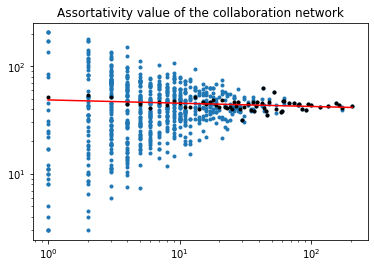

In [23]:
B = random_rewiring(A)
p, unique, knn, temp_knn = get_assortativity_value(B)
degrees = remove_zeros(get_degrees(B))

plt.title("Assortativity value of the collaboration network")
plt.loglog(degrees, temp_knn, marker=".", linestyle='None')
plt.loglog(unique, knn, marker = '.', linestyle='None', c='black')
plt.loglog(unique, np.exp(p[1] + np.log(unique)*p[0]), c = 'r')
print(p[0])
plt.show()

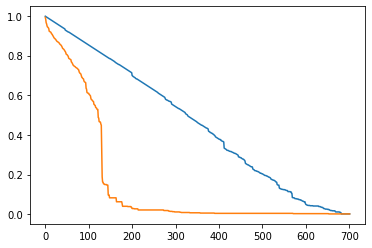

In [24]:
random_removal, attack_removal = check_robustness(A)
plt.plot(np.array(random_removal)/N)
plt.plot(np.array(attack_removal)/N)